# Imports

In [165]:
# importing libraries

import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import sklearn
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import xgboost as xgb
from catboost import CatBoostClassifier, Pool




In [166]:
# importing the data

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [167]:
warnings.filterwarnings("ignore") # ignoring warnings
np.random.seed(20) # setting a random seed for reproducability

# Data overview and cleaning

### Data notes:
- embarked:	Port of Embarkation	(C = Cherbourg, Q = Queenstown, S = Southampton)
- survival:	Survival	(0 = No, 1 = Yes)

In [168]:
print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [169]:
print(test.head())

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  


In [170]:
# ascertaining that no passenger occurs more than one in the data
train['PassengerId'].nunique()
test['PassengerId'].nunique()

418

- passenger id, ticket number, cabin number and name are unecessary for prediction purposes and do not add value to the data - dropping them from the list of features

In [171]:
features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked'] # list of all relevant features
train = train[features + ['Survived']] # defining training data: relevant features and target
train.head()
test = test[features] # defining test data: relevant features
test.head()

test_matcher = pd.read_csv('/kaggle/input/titanic/test.csv', usecols = features + ['PassengerId']) # df to use later to match the test set predictions to the right passenger ID to upload prediciton results to kaggle


In [172]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
 7   Survived  891 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


- data contains 891 passengers
- columns Age, and Embarked contain missing values
- dataset consists mostly of integers; Age and Fare are float variables

In [173]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


- test data contains 418 passengers
- columns age and fare contain missing values

# Exploratory Data Analysis

concentrating on the training data for the exploratory analysis

In [174]:
print(train.describe(include = 'all').transpose())

          count unique   top freq       mean        std   min     25%  \
Pclass    891.0    NaN   NaN  NaN   2.308642   0.836071   1.0     2.0   
Sex         891      2  male  577        NaN        NaN   NaN     NaN   
Age       714.0    NaN   NaN  NaN  29.699118  14.526497  0.42  20.125   
SibSp     891.0    NaN   NaN  NaN   0.523008   1.102743   0.0     0.0   
Parch     891.0    NaN   NaN  NaN   0.381594   0.806057   0.0     0.0   
Fare      891.0    NaN   NaN  NaN  32.204208  49.693429   0.0  7.9104   
Embarked    889      3     S  644        NaN        NaN   NaN     NaN   
Survived  891.0    NaN   NaN  NaN   0.383838   0.486592   0.0     0.0   

              50%   75%       max  
Pclass        3.0   3.0       3.0  
Sex           NaN   NaN       NaN  
Age          28.0  38.0      80.0  
SibSp         0.0   1.0       8.0  
Parch         0.0   0.0       6.0  
Fare      14.4542  31.0  512.3292  
Embarked      NaN   NaN       NaN  
Survived      0.0   1.0       1.0  


- mean of survived smaller than 0.5 - most passengers did not survive
- mean age was about 29.7, the youngest passenger was less than a year old, the oldest passenger was 80
- mean fare was 32.2 pounds

## Univariate analysis of categorical features

In [175]:
categorical_features = ['Pclass','Sex','Embarked'] # defining list of categorical features

#### Creating a function for plots:

In [176]:
def CreateCountplot(variable):
    total = len(train) # count of all passengers to use for percentages later
    ax = sns.countplot(y=variable, data=train, palette="twilight",order=train[variable].value_counts().index) # defining the countplot, setting a palette, sorting by number of passengers
    for p in ax.patches:
        pct = 100 * p.get_width() / total # defining the percentages
        ax.text(p.get_width() + 1, p.get_y() + p.get_height()/2, 
                f"{p.get_width():,.0f} ({pct:.1f}%)",verticalalignment='center') # defining position of annotations
    plt.title("number of passengers by {} : absolute and % share".format(variable)) # defining a title
    plt.show()

#### Using the function on all categorical variables:

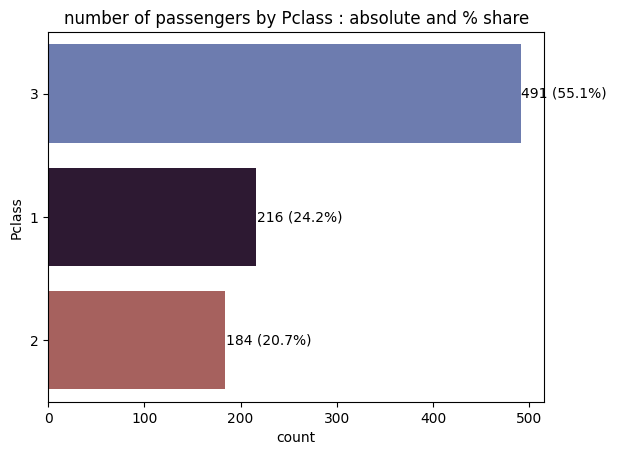

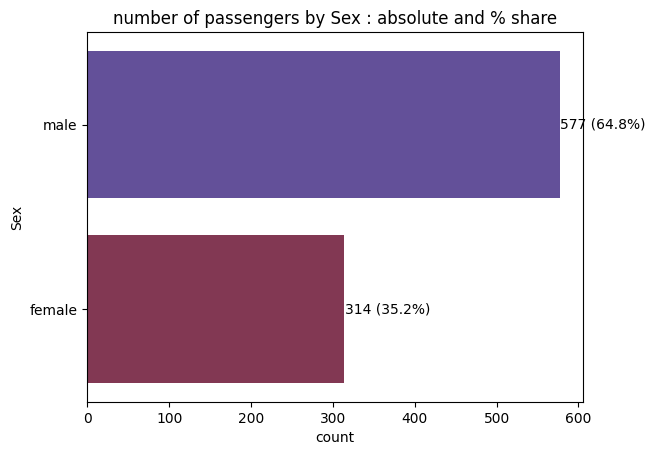

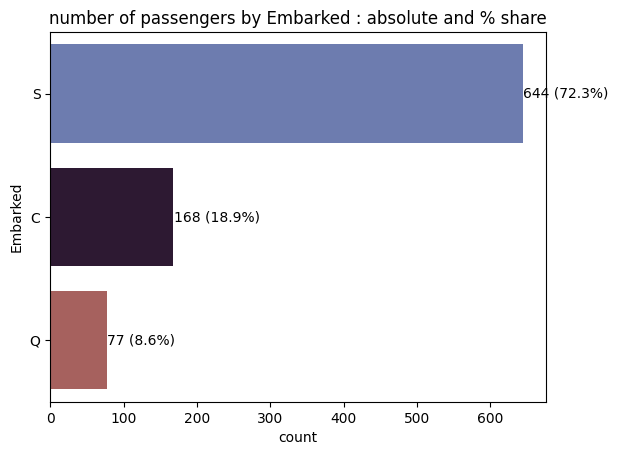

In [177]:
for feature in categorical_features:
    CreateCountplot(feature)

- most passengers were in class 3, least in class 2
- 65 % of passengers were male
- 72% passengers embarked in Southhampton, 19% embarked in Cherbourg and only around 9% in Queenstown

## Univariate Analysis of Numerical Features

In [178]:
numerical_features = train[['Age','SibSp','Parch','Fare']].dropna() # making a df of all numerical variables and dropping missing values
numerical_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 714 entries, 0 to 890
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     714 non-null    float64
 1   SibSp   714 non-null    int64  
 2   Parch   714 non-null    int64  
 3   Fare    714 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 27.9 KB


#### Creating a function for plots:

In [ ]:
quantiles = ['25%','50%', '75%'] # defining the quantiles for the histogram
colors = ['green', 'red', 'blue'] # defining the colors for the quantiles

def HistogramBoxplot(variable):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5)) # defining a plotgrid for the subplots
    axes = axes.flatten() # flattening the axes to make indexing easier

    #for i, col in enumerate(numerical_features.columns): # enumerating over the numerical columns
    ax_histogram = axes[0] # placing the histogram in the first plot
    sns.histplot(data=numerical_features, x=variable, ax= ax_histogram, kde=True) # defining the histogram including the kde line
    desc = numerical_features[variable].describe() # getting the stats for each column including the quartiles
        #print(desc)
    for j, q in enumerate(quantiles): 
        ax_histogram.axvline(desc[q], color=colors[j]) # adding the colored lines for the 25th, 50th and 75th quartile


    ax_boxplot = axes[1] # placing the boxplots next to the corresponding histogram
    sns.boxplot(ax=ax_boxplot, data=numerical_features, x=variable, color = 'lightblue') # creating the boxplots for all the numerical variables

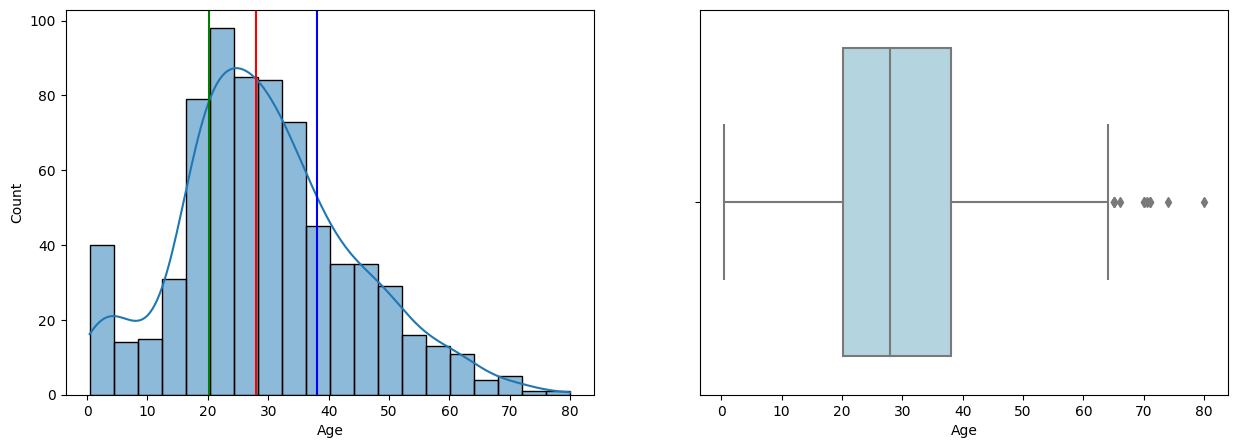

In [180]:
HistogramBoxplot('Age')

- age is slightly right skewed: most passengers are between 20 and 40 but there are some passengers that are up to 80 years old
- boxplot shows the few passengers over 65 as outliers

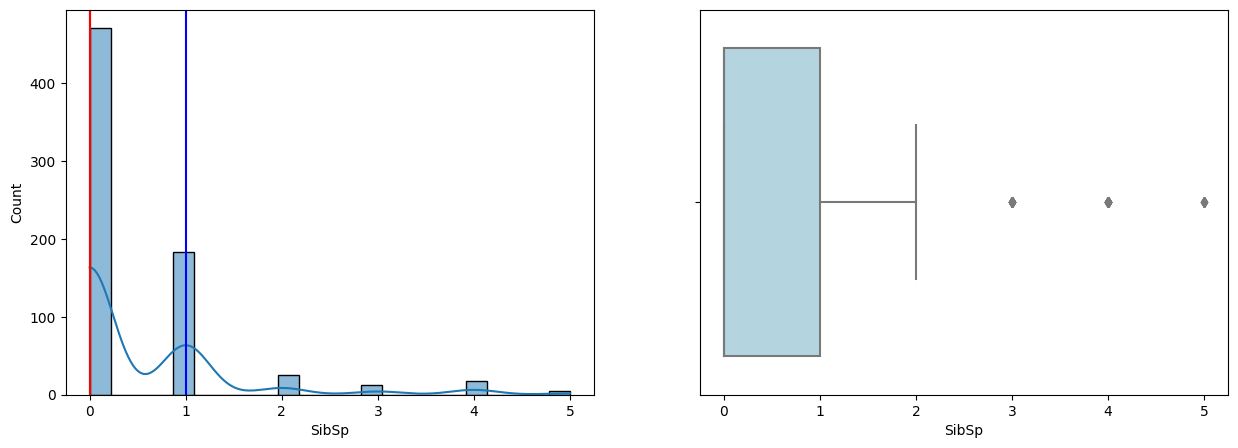

In [181]:
HistogramBoxplot('SibSp')

- most passengers did not bring any spouses or siblings on board, the 75% is at one spouse / sibling all values above 2 spouses/siblings are considered outliers

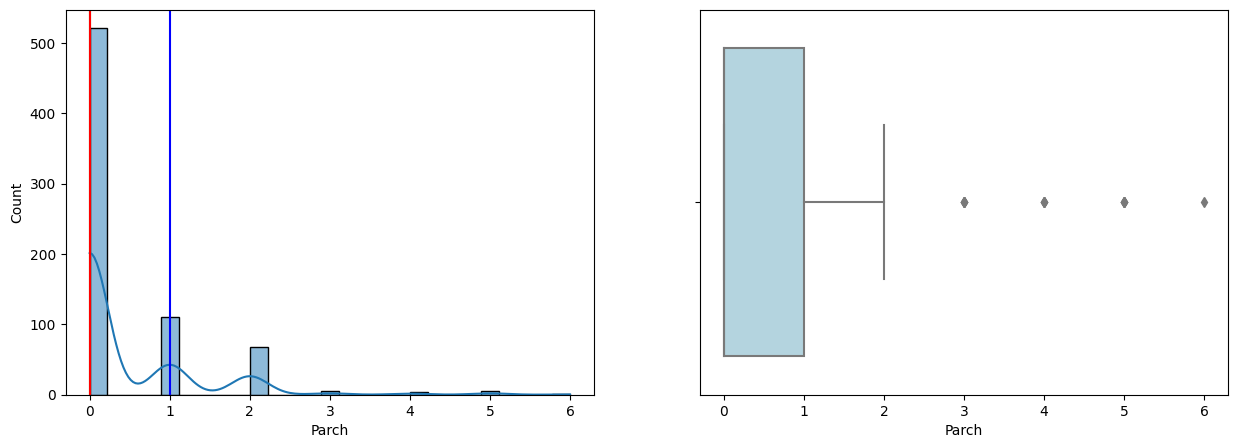

In [182]:
HistogramBoxplot('Parch')

- most passengers were not accompanied by parents or children either, all passengers that had 3 or more parents or children with them are considered as outliers

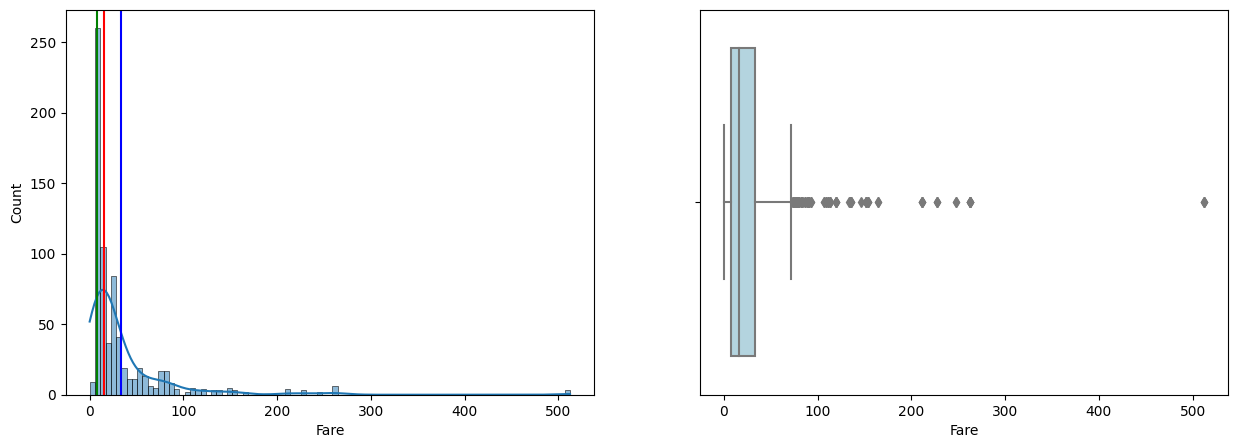

In [183]:
HistogramBoxplot('Fare')

- fare is relatively under 50 pounds for most passengers but goes up to 300 pounds for some and up to 500 pounds for 1 passenger
- distribution is right skewed with a long right tail

## Multivariate analysis: Numerical features

<Axes: >

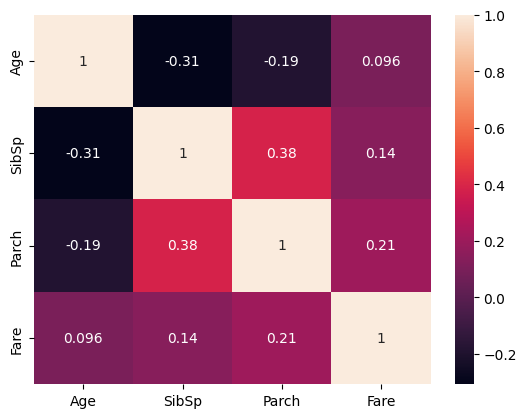

In [184]:
corr = numerical_features.corr() # calculating correlation of all numerical variables
sns.heatmap(corr, annot = True) # printing a heatmap of the correlation matrix

- there is some positive correlation between number of siblings/spouses and number of parents/children brought on board (0.38)
- the correlation between number of siblings / spouses brought and age is negative but not very strong as well (- 0.31)
- correlation between other numberical variables is below 30 % 

# Preparing data for model training

### Encoding object data types (text) into numbers to use in training

In [185]:
train['Sex'] = train['Sex'].map({'male': 0, 'female': 1}).astype(float)
test['Sex'] = test['Sex'].map({'male': 0, 'female': 1}).astype(float)

#C = Cherbourg, Q = Queenstown, S = Southampton
train['Embarked'] = train['Embarked'].map({'C': 0, 'Q': 1,'S': 2}).astype(float)
test['Embarked'] = test['Embarked'].map({'C': 0, 'Q': 1,'S': 2}).astype(float)

### Dropping Null values

In [186]:
train.isnull().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
Survived      0
dtype: int64

In [187]:
train = train.dropna()
train.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Survived    0
dtype: int64

### Splitting the training data into features and target

In [188]:
x = train.drop('Survived', axis = 1)
y = train['Survived']

### splitting the data into training and validation data to be able to evaluate the models as I build them

In [189]:
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size = 0.2)

In [190]:
print(y_train.info())
print('-'*30)
print(y_val.info())

<class 'pandas.core.series.Series'>
Index: 569 entries, 636 to 443
Series name: Survived
Non-Null Count  Dtype
--------------  -----
569 non-null    int64
dtypes: int64(1)
memory usage: 8.9 KB
None
------------------------------
<class 'pandas.core.series.Series'>
Index: 143 entries, 374 to 216
Series name: Survived
Non-Null Count  Dtype
--------------  -----
143 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB
None


- the validation set is relatively small (143 entries) but still large enough to evaluate performance during model building

In [191]:
### Defining a function to show a confusion matrix as well as the classification report for different models

In [192]:
def confusion_classification(Truth,Predicted):
    print(classification_report(Truth, Predicted))
    cm = confusion_matrix(Truth, Predicted)
    #plt.figure()
    sns.heatmap(cm, annot = True, fmt = '.0f')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

## Building and tuning a simple tree

- using Grid Search to find optimal hyperparameters for DecisionTreeClassifier
- iterating over:
- max tree depth: experimenting with values btw. 1 and 10
- min number of samples per leaf: experimenting with values btw. 2 and 20

In [193]:
tree1 = tree.DecisionTreeClassifier() # initializing the decision tree model

param_grid = {#'criterion': ['gini','entropy','log_loss'], # setting the parameter grid
             'max_depth': np.arange(1,10),
             'min_samples_leaf': [2,3,5,10,15,20]
             }

gridcv = GridSearchCV(tree1, param_grid, scoring = 'accuracy')  # choosing accuracy as the scoring metric

gridcv = gridcv.fit(x_train, y_train) # fitting the grid search on the train data

tree1_best_estimator = gridcv.best_estimator_  # saving the best estimator - tree with best hyperparameters

tree1_best_estimator.fit(x_train, y_train)  # fitting the tree with optimized hyperparameters


DecisionTreeClassifier(max_depth=3, min_samples_leaf=3)

#### Performance on training and validation data

In [194]:
train_pred1 = tree1_best_estimator.predict(x_train)
accuracy_score(y_train, train_pred1)

0.8295254833040422

In [195]:
val_pred1 = tree1_best_estimator.predict(x_val)
accuracy_score(y_val, val_pred1)

0.7902097902097902

- validation accuracy is lower than training accuracy - model overfits slightly

## Building and Tuning an XGBoost model

Tuning the following hyperparameters:
- max depth of the trees
- learning rate
- number of trees in the ensemble
- minimum (hessian) instance weight of a leaf node

In [196]:
ensemble1 = xgb.XGBClassifier()

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [20, 50, 100, 200],
    'min_child_weight': [1,2,3]
    }


gridcv = GridSearchCV(ensemble1, param_grid, scoring = 'accuracy')

gridcv = gridcv.fit(x_train, y_train) # fitting the grid search on the train data

ensemble1_best_estimator = gridcv.best_estimator_  # saving the best estimator 
ensemble1_best_estimator.fit(x_train, y_train)  # fitting the model with optimized hyperparameters

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### Performance on training and validation data

In [197]:
# predictions on the training data
train_pred2 = ensemble1_best_estimator.predict(x_train)
accuracy_score(y_train, train_pred2)

0.9103690685413005

- training accuracy is slightly higher than for the tree model above

              precision    recall  f1-score   support

           0       0.81      0.84      0.83        82
           1       0.78      0.74      0.76        61

    accuracy                           0.80       143
   macro avg       0.79      0.79      0.79       143
weighted avg       0.80      0.80      0.80       143



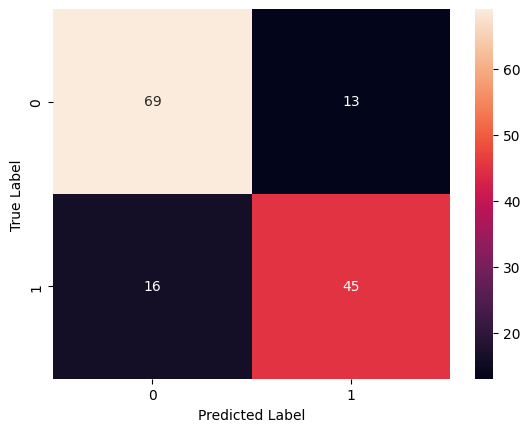

In [198]:
# predictions on the validation set
val_pred2 = ensemble1_best_estimator.predict(x_val)
accuracy_score(y_val, val_pred2)

confusion_classification(y_val, val_pred2)

- validation accuracy is at 80% which is a small improvement from the 79% of the simple tree model
- precision and recall are higher for class 0 (deceased) than for class 1: the model makes fewer mistakes identifying deceased passengers and also finds more of them 
- 16 passengers are mistaken for causalties by the model and 13 passengers misclassified as survivors.
- model overfits - accuracy on the training data does not carry over to the new validation data

## Building and Tuning a Catboost model

- tuning learning rate, maximum depth of the trees and the number of trees in the ensemble

In [199]:
ensemble2 = CatBoostClassifier()

param_grid = {
    #'iterations': []
    'learning_rate': [0.1, 0.01, 0.05],
    'max_depth': [3, 5, 7],
    #l2_leaf_reg':,
    #'model_size_reg':
    'n_estimators': [20, 50, 100, 200]
    }

gridcv = GridSearchCV(ensemble2, param_grid, scoring = 'accuracy')

gridcv = gridcv.fit(x_train, y_train, verbose = 0) # fitting the grid search on the train data

ensemble2_best_estimator = gridcv.best_estimator_  # saving the best estimator

ensemble2_best_estimator.fit(x_train, y_train, verbose = 0)  # fitting the model with optimized hyperparameters

#### Performance on training and validation data

In [200]:
train_pred3 = ensemble2_best_estimator.predict(x_train)
accuracy_score(y_train, train_pred3)

0.8998242530755711

              precision    recall  f1-score   support

           0       0.81      0.85      0.83        82
           1       0.79      0.74      0.76        61

    accuracy                           0.80       143
   macro avg       0.80      0.80      0.80       143
weighted avg       0.80      0.80      0.80       143



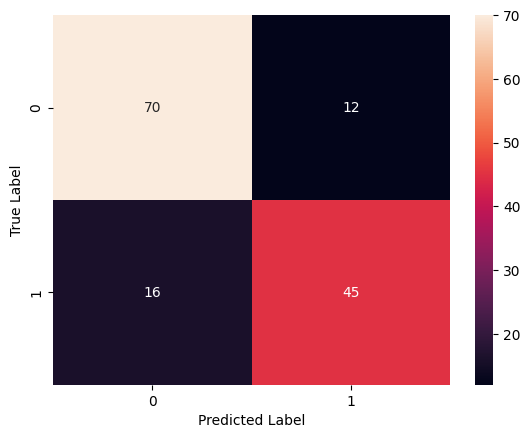

In [201]:
val_pred3 = ensemble2_best_estimator.predict(x_val)
confusion_classification(y_val, val_pred3)

- at 80% accuracy performance is similar to the XGBoost model
- precision and recall are higher for class 0 (deceased) for the Catboost model as well
- model overfits slightly as well

# Deciding on a best model and submitting the test set results to the competition

- both the XGBoost and the Catboost model have an accuracy of 80% on the validation set, so I could use either for retraining
- choosing the Catboost classifier

In [202]:
ensemble2_best_estimator.fit(x, y, verbose = 0)  # fitting the model with all data
test_pred = ensemble2_best_estimator.predict(test) # making predictions on the test dataset provided by kaggle

# generating the data frame for submission
submission = pd.DataFrame(test_matcher['PassengerId']) # fetching the passenger ids from the test matcher df created earlier
print(submission.head(10))

submission.insert(1, "Survived", test_pred, True) # inserting the predictions from test_pred into the submission df - predicitions are now matched to passengers
submission["Survived"] = pd.to_numeric(submission["Survived"], downcast="integer") # converting results to numeric
print(submission.head(10))

submission.to_csv("submission.csv", index=False)

   PassengerId
0          892
1          893
2          894
3          895
4          896
5          897
6          898
7          899
8          900
9          901
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0
